# Imports

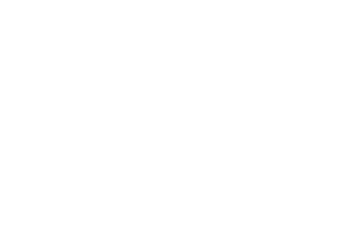

In [1]:
from pandas import json_normalize
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.axis('off')
import spacy
nlp = spacy.load("en")
from collections import Counter
import json
%tensorflow_version 2.x
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences 
from pprint import pprint
from gensim import corpora, models
import re
import string
import pickle

# Initial Setup

In [2]:
with open('the_weeknd.json') as json_data:
    data = json.load(json_data)

In [3]:
df = pd.DataFrame(
    data['songs'], 
    columns=[
             'title',
             'lyrics',
             'album',
             'release_date',
             'description',
             'recording_location',
             ]
    )
df['release_date'] = pd.to_datetime(df['release_date'])
df['description'] = [
                     desc['plain']
                     if desc['plain'] != '?'
                     else np.nan
                     for desc in df['description']
]
df['album'] = [album['name'].strip() if album else np.nan for album in df['album']]
df = df[
   ~df['album'].isin(['Wanderlust (Remixes)', 'Video Breakdowns'])
]
df['album'] = df['album'].str.replace("\(Original Motion Picture Soundtrack\)", "")

In [4]:
df.head()

,title,lyrics,album,release_date,description,recording_location
0,The Hills,"Yeah\nYeah\nYeah\n\nYour man on the road, he d...",Beauty Behind the Madness,2015-05-27,Originally nicknamed “Mood Music” and first te...,None
1,Starboy,"I'm tryna put you in the worst mood, ah\nP1 cl...",Starboy,2016-09-21,“Starboy” is The Weeknd’s realization of his m...,"Conway Recording Studios, Los Angeles, CA"
2,Can’t Feel My Face,And I know she'll be the death of me\nAt least...,Beauty Behind the Madness,2015-06-08,"This song personifies drug addiction, likening...",None
3,Reminder,Record man play my song on the radio\nYou too ...,Starboy,2016-11-25,“Reminder” is Abel’s response to his critics f...,None
4,Call Out My Name,We found each other\nI helped you out of a bro...,The Weeknd in Japan,2018-03-30,Sampling his Oscar-nominated “Earned It” over ...,None


In [5]:
kiss_land_release = '2013-10-10'
df['is_trilogy_era'] = (df['release_date'] <= kiss_land_release) | (df['album'] == "Unreleased Songs")

In [6]:
trilogy_era = df[df['is_trilogy_era']]
modern_era = df[~df['is_trilogy_era']]
print("Trilogy - Kiss Land samples:")
print(len(trilogy_era))
print("Post Kiss Land samples:")
print(len(modern_era))

Trilogy - Kiss Land samples:
114
Post Kiss Land samples:
99


In [7]:
print("Total words through entire dataset: ", int(df['lyrics'].str.split().str.len().sum()))
print("Total words through Trilogy - Kiss Land data:", int(trilogy_era['lyrics'].str.split().str.len().sum()))
print("Total words in post Kiss Land data:", int(modern_era['lyrics'].str.split().str.len().sum()))

Total words through entire dataset:  68878
Total words through Trilogy - Kiss Land data: 39288
Total words in post Kiss Land data: 29590


# Data Vizualization

In [8]:
px.histogram(
    df,
    x='album', 
    color='is_trilogy_era',
    title="Count of songs per album"
).update_xaxes(categoryorder="total descending").show()

In [9]:
px.histogram(
    df[df['album']!="Unreleased Songs"],
    x='album', 
    color='is_trilogy_era',
    title="Count of songs per album excluding unreleased"
).update_xaxes(categoryorder="total descending").show()

In [10]:
px.histogram(
    df,
    x='recording_location',
    color='is_trilogy_era',
    title="Count of songs recorded in respective studio"
).update_xaxes(categoryorder="total descending").show()

In [11]:
def determine_recording_city(recording_location: str):
    if not recording_location:
        return np.nan
    if '(' in recording_location:
        res = re.findall(r'\((.*?) *\)', recording_location)
        return " & ".join(sorted(set(res)))
    elif ',' in recording_location:
        res = recording_location.split(',')[-2:]
        return ", ".join(c.strip() for c in res)
    else:
        return np.nan

In [12]:
df['condensed_recording_location'] = df['recording_location'].apply(
    determine_recording_city
)
px.histogram(
    df.dropna(),
    x='release_date',
    color='condensed_recording_location',
    title="Count per respective recording studio, with locations condensed"
)

In [13]:
# when creating word clouds, maps word fontsize to a color
# https://github.com/amueller/word_cloud/issues/256
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

In [14]:
exclusions = (
    "go",
    "wanna",
    "oh",
    "get",
    "yes",
    "ooh",
    "be",
    "gon",
    "hey",
    "na",
    "woah",
    "let",
    "ahh",
    "ohh",
    "i\'mma",
    "imma",
    "tryna",
    "ah",
    "big",
    "til'",
    "whoa",
    "because"
)
def get_lemmas(lyrics_series: pd.Series):
    lyrics = lyrics_series.str.lower().str.strip().values
    lemmas = [
              [
               word.lemma_
               for word
               in nlp.tokenizer(lyric)
               if not word.is_punct
               and not word.is_stop
               and not word.is_space
               and not word.lemma_ == '-PRON-'
               and word.lemma_ not in exclusions
              ]
              for lyric
              in lyrics
              if lyric
    ]
    return lemmas 

flatten = lambda lyrics: [word for lyric in lyrics for word in lyric]

In [15]:
lemmas = get_lemmas(df['lyrics'])
trilogy_lemma = get_lemmas(trilogy_era['lyrics'])
modern_lemma = get_lemmas(modern_era['lyrics'])

In [16]:
temp_df = df[~df['lyrics'].isna()]
temp_df['lemmas'] = lemmas
temp_df.drop(temp_df[temp_df['album']=="Unreleased Songs"].index, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Most Frequent words per Album

In [69]:
album_to_lyrics = temp_df.groupby('album')['lemmas'].sum().to_frame()
# album_to_lyrics.reset_index(inplace=True)
album_to_lyrics['most_common'] = album_to_lyrics['lemmas'].apply(
    lambda lemmas: set(word for word, _ in Counter(lemmas).most_common(3))
)
pd.DataFrame(
    album_to_lyrics['most_common'].to_list(), 
    index=album_to_lyrics.index,
    columns=[1,2,3]
)

,1,2,3
album,,,
After Hours,know,love,heartless
After Hours (Deluxe),know,close,like
Beauty Behind the Madness,know,love,life
Blinding Lights,light,say,touch
Echoes of Silence,want,baby,know
Fifty Shades of Grey,belong,want,remind
House of Balloons,girl,want,la
Kiss Land (Deluxe),little,love,like
"My Dear Melancholy,",know,try,lo


In [70]:
temp_df = temp_df[~temp_df['condensed_recording_location'].isna()]
location_to_lyrics = temp_df.groupby('condensed_recording_location')['lemmas'].sum().to_frame()
location_to_lyrics['most_common'] = location_to_lyrics['lemmas'].apply(
    lambda lemmas: set(word for word, _ in Counter(lemmas).most_common(3))
)
pd.DataFrame(
    location_to_lyrics['most_common'].to_list(),
    index=location_to_lyrics.index,
    columns=[1,2,3]
)

,1,2,3
condensed_recording_location,,,
"Hidden Hills, CA",feel,lose,love
"Hidden Hills, CA & Los Angeles, CA",know,sky,count
"Hidden Hills, CA & Toronto, ON",life,metro,heartless
"Las Vegas, NV",little,diamond,precious
"Los Angeles, CA",baby,know,love
"Los Angeles, CA & Malibu, CA",heart,baby,hold
"Los Angeles, CA & New York, NY",light,say,touch
"Los Angeles, CA & New York, NY & Stockholm, Sweden",save,tear,run
"Los Angeles, CA & Stockholm, Sweden",know,eye,try


## Most Frequent Words per 'Era'

Most frequent words throughout all lyrics

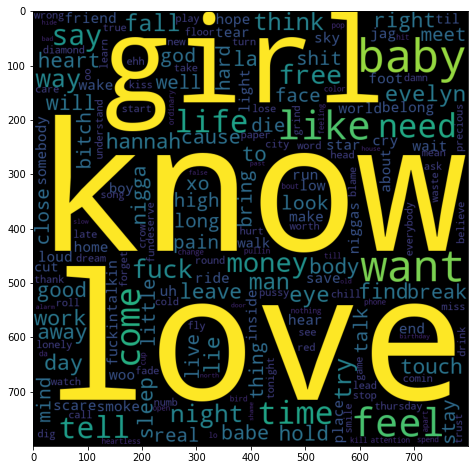

In [31]:
plt.imshow(
    WordCloud(
        width=800,
        height=800, 
        collocations=False,
        color_func=colormap_size_func('viridis', 100),
        ).generate_from_frequencies(Counter(flatten(lemmas)))
)

Most frequent words through Trilogy + Kiss Land

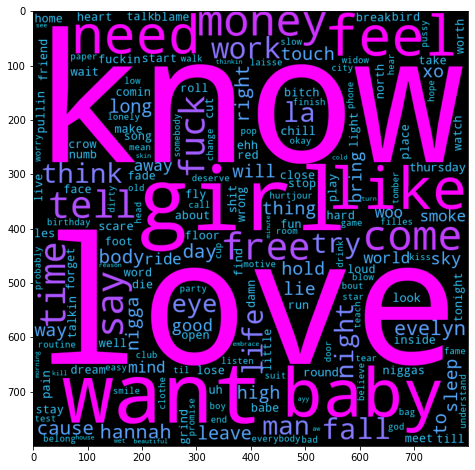

In [28]:
plt.imshow(
    WordCloud(
        width=800,
        height=800, 
        collocations=False,
        color_func=colormap_size_func('cool', 100),
        ).generate_from_frequencies(Counter(flatten(trilogy_lemma)))
)

Most frequent words through Post - Kiss Land

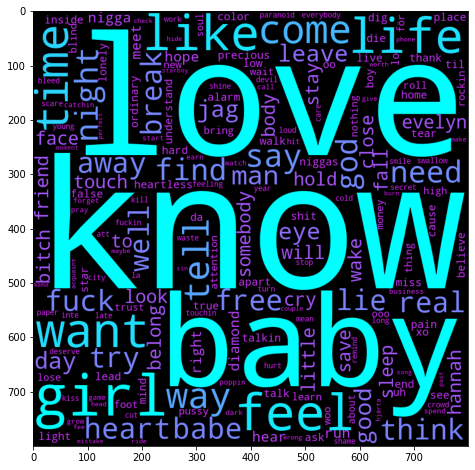

In [29]:
plt.imshow(
    WordCloud(
        width=800,
        height=800,
        collocations=False,
        color_func=colormap_size_func('cool_r', 100),
        ).generate_from_frequencies(Counter(flatten(modern_lemma)))
)

# Topic Modelling

In [32]:
def generate_corpus(lemmas, tfidf: bool = False):
    words = corpora.Dictionary(lemmas)
    words.filter_extremes(no_above=0.4, keep_n=100000)
    corpus = [words.doc2bow(doc) for doc in lemmas]
    if tfidf:
        tfidf = models.TfidfModel(corpus)
        corpus_tfidf = tfidf[corpus]
        return corpus_tfidf, words
    else:
        bow_corpus = corpus
        return bow_corpus, words

In [33]:
def generate_topic_models(lemmas):
    corpus, words = generate_corpus(lemmas, False)
    lda = models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=words,
        random_state=21,
        num_topics=3,
        alpha='auto',
        update_every=5,
        eval_every=1,
        per_word_topics=False,
    )
    return lda

In [34]:
trilogy_topics = generate_topic_models(trilogy_lemma)

In [35]:
pprint(trilogy_topics.show_topics())

[(0,
  '0.044*"come" + 0.036*"time" + 0.018*"say" + 0.017*"fuck" + 0.017*"try" + '
  '0.016*"night" + 0.014*"eye" + 0.014*"sleep" + 0.014*"lie" + 0.013*"smoke"'),
 (1,
  '0.032*"say" + 0.029*"fall" + 0.023*"man" + 0.022*"life" + 0.019*"cause" + '
  '0.017*"touch" + 0.015*"fuck" + 0.014*"nigga" + 0.014*"good" + '
  '0.014*"right"'),
 (2,
  '0.052*"money" + 0.038*"free" + 0.031*"work" + 0.016*"day" + 0.014*"woo" + '
  '0.013*"bring" + 0.013*"xo" + 0.013*"high" + 0.012*"fuck" + 0.011*"eye"')]


In [36]:
modern_topics = generate_topic_models(modern_lemma)

In [37]:
pprint(modern_topics.show_topics())

[(0,
  '0.038*"life" + 0.028*"belong" + 0.026*"leave" + 0.024*"night" + '
  '0.023*"away" + 0.023*"little" + 0.023*"say" + 0.021*"real" + 0.019*"come" + '
  '0.018*"day"'),
 (1,
  '0.038*"tell" + 0.036*"god" + 0.021*"need" + 0.021*"look" + 0.019*"hold" + '
  '0.016*"try" + 0.016*"xo" + 0.015*"think" + 0.015*"wake" + 0.015*"face"'),
 (2,
  '0.037*"come" + 0.034*"life" + 0.031*"way" + 0.024*"babe" + 0.023*"find" + '
  '0.019*"fuck" + 0.019*"heart" + 0.018*"break" + 0.015*"cry" + 0.015*"say"')]


In [38]:
plt.style.use('dark_background')
def topic_visualization(topic_probs: dict, topics_words: list):
    labels = [f"Topic {topic}" for topic in topic_probs.keys()]
    data = np.array(list(topic_probs.values()))
    data /= data.sum(axis=1, keepdims=True)
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('cool')(
        np.linspace(0.15, 0.85, data.shape[1]))
    topics_words = np.array(topics_words).T
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (color, topic_words) in enumerate(zip(category_colors, topics_words)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                color=color)
        xcenters = starts + widths / 2
        r, g, b, _ = color
        text_color = 'black' #'white' if r * g * b < 0.5 else 'gray'
        for y, (x, c, topic_word) in enumerate(zip(xcenters, widths,
                                                   topic_words)):
            ax.text(x, y, topic_word, ha='center', va='center',
                    color=text_color)
    return fig, ax

In [39]:
def topic_model_to_visualization(topic_model):
    topics_dict = {}
    topics_labels = []
    for (topic, probabilities) in topic_model.show_topics(formatted=False):
        topics_dict[topic] = [probability for _, probability in probabilities]
        topics_labels.append([word for word, _ in probabilities])
    return topics_dict, topics_labels

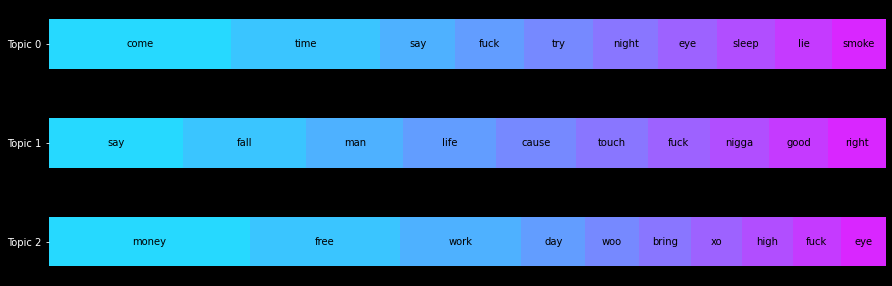

In [40]:
topic_visualization(*topic_model_to_visualization(trilogy_topics))
plt.show()

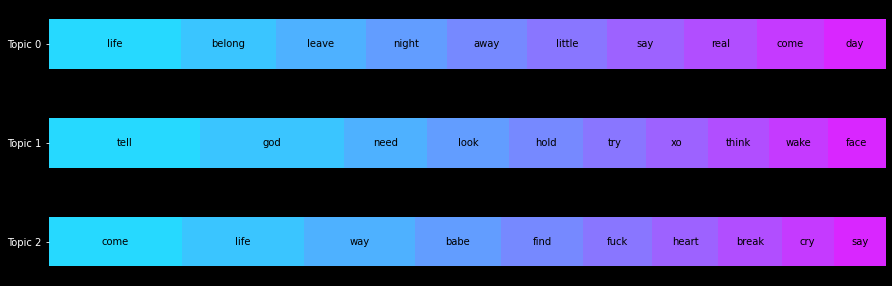

In [41]:
topic_visualization(*topic_model_to_visualization(modern_topics))
plt.show()

# Text Generation

In [ ]:
def create_token_data(lyrics_series):
    all_lyrics = lyrics_series.str.lower().str.cat(sep=" ")
    token_data = [
                  token.orth_ 
                  for token in nlp.tokenizer(all_lyrics) 
                  if not token.is_space
                  and not token.orth_ in ('(', ')')
                  ]
    return token_data

In [ ]:
trilogy_data = create_token_data(trilogy_era['lyrics'])

In [ ]:
modern_data = create_token_data(modern_era['lyrics'])

In [ ]:
len_0 = 15
len_1 = len_0 + 1

def generate_sequences(data):
    sequences = []
    for i in range(len(data)-len_1+1):
        sequence = data[i:i+len_1]
        sequences.append(sequence)
    return sequences

In [ ]:
pprint(generate_sequences(trilogy_data)[0])
print()
print(' '.join(generate_sequences(trilogy_data)[0]))

['woah',
 ',',
 'woah',
 ',',
 'ehh',
 'i',
 'left',
 'my',
 'girl',
 'back',
 'home',
 'i',
 'do',
 "n't",
 'love',
 'her']

woah , woah , ehh i left my girl back home i do n't love her


In [ ]:
trilogy_sequences = generate_sequences(trilogy_data)
modern_sequences = generate_sequences(modern_data)

In [ ]:
def fit_tokenizer(sequences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sequences)
    sequences = tokenizer.texts_to_sequences(sequences)
    return np.array(sequences), tokenizer

In [ ]:
trilogy_numeric_sequences, trilogy_tokenizer = fit_tokenizer(trilogy_sequences)
modern_numeric_sequences, modern_tokenizer = fit_tokenizer(modern_sequences)

In [ ]:
print(trilogy_numeric_sequences[0].tolist())
for num in trilogy_numeric_sequences[0]:
    print(trilogy_tokenizer.index_word[num], end=" ")

[67, 1, 67, 1, 208, 2, 322, 18, 28, 111, 180, 2, 7, 8, 24, 55]
woah , woah , ehh i left my girl back home i do n't love her 

In [ ]:
trilogy_vocab_size = len(trilogy_tokenizer.word_counts)
modern_vocab_size = len(modern_tokenizer.word_counts)

In [ ]:
def X_y_split(sequences, vocab_count):
    X = sequences[:, :-1]
    y = sequences[:, -1]
    y = to_categorical(y, num_classes=vocab_count+1)
    return X, y

In [ ]:
X_trilogy, y_trilogy = X_y_split(trilogy_numeric_sequences, trilogy_vocab_size)
X_modern, y_modern = X_y_split(modern_numeric_sequences, modern_vocab_size)

In [ ]:
def create_model(vocab_size, seq_len, name):
    
    model = Sequential(name=name)
    model.add(Embedding(vocab_size, output_dim=seq_len, input_length=seq_len))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])
        
    model.summary()
    print()
            
    return model

In [ ]:
trilogy_model = create_model(trilogy_vocab_size+1, len_0, 'trilogy')
modern_model = create_model(modern_vocab_size+1, len_0, 'modern')

Model: "trilogy"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 15)            37230     
_________________________________________________________________
lstm (LSTM)                  (None, 15, 50)            13200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 2482)              126582    
Total params: 199,762
Trainable params: 199,762
Non-trainable params: 0
_________________________________________________________________

Model: "modern"
_________________________________________________________________
Layer (type)                 Output 

In [ ]:
trilogy_model.fit(X_trilogy, y_trilogy, batch_size=128, epochs=100)

Epoch 1/100
366/366 [==============================] - 3s 8ms/step - loss: 2.5229 - accuracy: 0.4402
Epoch 2/100
366/366 [==============================] - 3s 8ms/step - loss: 2.4909 - accuracy: 0.4465
Epoch 3/100
366/366 [==============================] - 3s 8ms/step - loss: 2.4647 - accuracy: 0.4510
Epoch 4/100
366/366 [==============================] - 3s 8ms/step - loss: 2.4382 - accuracy: 0.4539
Epoch 5/100
366/366 [==============================] - 3s 8ms/step - loss: 2.4151 - accuracy: 0.4596
Epoch 6/100
366/366 [==============================] - 3s 8ms/step - loss: 2.3877 - accuracy: 0.4646
Epoch 7/100
366/366 [==============================] - 3s 8ms/step - loss: 2.3687 - accuracy: 0.4668
Epoch 8/100
366/366 [==============================] - 3s 8ms/step - loss: 2.3439 - accuracy: 0.4730
Epoch 9/100
366/366 [==============================] - 3s 8ms/step - loss: 2.3203 - accuracy: 0.4760
Epoch 10/100
366/366 [==============================] - 3s 8ms/step - loss: 2.3000 - accura

In [ ]:
modern_model.fit(X_modern, y_modern, batch_size=128, epochs=100)

Epoch 1/100
278/278 [==============================] - 2s 8ms/step - loss: 5.8935 - accuracy: 0.0737
Epoch 2/100
278/278 [==============================] - 2s 8ms/step - loss: 5.5635 - accuracy: 0.0768
Epoch 3/100
278/278 [==============================] - 2s 8ms/step - loss: 5.3983 - accuracy: 0.0770
Epoch 4/100
278/278 [==============================] - 2s 8ms/step - loss: 5.1358 - accuracy: 0.0900
Epoch 5/100
278/278 [==============================] - 2s 8ms/step - loss: 4.8692 - accuracy: 0.1105
Epoch 6/100
278/278 [==============================] - 2s 8ms/step - loss: 4.6847 - accuracy: 0.1244
Epoch 7/100
278/278 [==============================] - 2s 8ms/step - loss: 4.5536 - accuracy: 0.1330
Epoch 8/100
278/278 [==============================] - 2s 8ms/step - loss: 4.4467 - accuracy: 0.1430
Epoch 9/100
278/278 [==============================] - 2s 8ms/step - loss: 4.3514 - accuracy: 0.1533
Epoch 10/100
278/278 [==============================] - 2s 8ms/step - loss: 4.2586 - accura

In [ ]:
loss, accuracy = trilogy_model.evaluate(X_trilogy, y_trilogy)
print("Trilogy model metrics:")
print(f"loss: {loss}, accuracy: {accuracy}")

1462/1462 [==============================] - 7s 5ms/step - loss: 1.1661 - accuracy: 0.7144
Trilogy model metrics:
loss: 1.166137456893921, accuracy: 0.7144384980201721


In [ ]:
loss, accuracy = modern_model.evaluate(X_modern, y_modern)
print("Modern model metrics:")
print(f"loss: {loss}, accuracy: {accuracy}")

1111/1111 [==============================] - 5s 5ms/step - loss: 1.2684 - accuracy: 0.6912
Modern model metrics:
loss: 1.2683522701263428, accuracy: 0.6911628246307373


In [ ]:
def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words, temperature):
    
    output_text = []
    
    input_text = seed_text
    
    for _ in range(num_gen_words):
        # Encode input text. 
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
         # Add if the input text does not have length len_0.
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
        # Get learned distribution.
        pred_distribution = model.predict(pad_encoded, verbose=0)[0]
        
        # Apply temperature transformation.
        new_pred_distribution = np.power(pred_distribution, (1 / temperature)) 
        new_pred_distribution = new_pred_distribution / new_pred_distribution.sum()
        
        # Sample from modified distribution.
        choices = range(new_pred_distribution.size)
 
        pred_word_ind = np.random.choice(a=choices, p=new_pred_distribution)
        
        # Convert from numeric to word. 
        pred_word = tokenizer.index_word[pred_word_ind]
        if (
            ('\'' in pred_word and not pred_word.startswith('\'')) 
            or pred_word == ','
            or pred_word in string.punctuation
        ):
            pred_word = '\b' + pred_word
        # Attach predicted word. 
        input_text += ' ' + pred_word
        # Append new word to the list. 
        output_text.append(pred_word)
        
    return ' '.join(output_text)

In [ ]:
sample = "all this pain,"
trilogy_generated = generate_text(trilogy_model, trilogy_tokenizer, len_0, sample, 40, 10)
modern_generated = generate_text(modern_model, modern_tokenizer, len_0, sample, 40, 10)
print(sample, trilogy_generated)
print()
print(sample, modern_generated)

all this pain, so keep anything my mind pass stop tonight how ooh my kids heard take long me knows step all there shakin are feelin there abel visions ai ' no me nothing ride times where just what about holding into your

all this pain, ooh another patient getting who star on day ah felt trying yet more face hard til them gon of got alone winnin like acquainted are 's between there girl it there thinking everybody want girls i last bitch show bout


In [ ]:
start = np.random.randint(200)
lyric = ' '.join(trilogy_data[start:start+30])
print(lyric)
print()
seed = ' '.join(trilogy_data[start:start+10])
print(seed)
print(generate_text(trilogy_model, trilogy_tokenizer, len_0, seed, 20, 3))
print()
print(seed)
print(generate_text(modern_model, modern_tokenizer, len_0, seed, 20, 3))

me all of it , i need all of it to myself woah , woah so tell me you love me only for tonight , only for the night even

me all of it , i need all of it
even tryna that with ta gone ? where i need man why shots in like " back yeah like ah

me all of it , i need all of it
thank my will know you ca this a kiss and then i 'm much glad they said baby even catch


In [ ]:
trilogy_model.save('trilogy_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: trilogy_model/assets


In [ ]:
modern_model.save('modern_model')

INFO:tensorflow:Assets written to: modern_model/assets


In [ ]:
!zip -r trilogy.zip trilogy_model/

  adding: trilogy_model/ (stored 0%)
  adding: trilogy_model/saved_model.pb (deflated 90%)
  adding: trilogy_model/variables/ (stored 0%)
  adding: trilogy_model/variables/variables.index (deflated 66%)
  adding: trilogy_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: trilogy_model/assets/ (stored 0%)


In [ ]:
!zip -r modern.zip modern_model/

  adding: modern_model/ (stored 0%)
  adding: modern_model/saved_model.pb (deflated 90%)
  adding: modern_model/variables/ (stored 0%)
  adding: modern_model/variables/variables.index (deflated 65%)
  adding: modern_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: modern_model/assets/ (stored 0%)


In [ ]:
with open('trilogy_tokenizer.pickle', 'wb') as pickle_file:
    pickle.dump(trilogy_tokenizer, pickle_file, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('modern_tokenizer.pickle', 'wb') as pickle_file:
    pickle.dump(modern_tokenizer, pickle_file, pickle.HIGHEST_PROTOCOL)